# Media Mix Modeling with Carryover and Saturation Effects Using Bayesian Methods

This notebook provides a solution for the media mix modeling (MMM) problem using Bayesian methods.

### Use Case
We are looking to estimate the efficiency of different marketing activities or channels and provide a guidance for future investments and budget allocations. We assume that historical metrics about the intensity of different marketing activities are available in the form of time series, as well as the performance metric (revenue, number of conversions, site traffic, etc.). Our goal is to estimate the average contribution of each activity/channel. More formally:
  * We assume a company that runs promotion and advertising activities using several marketing channels.
  * For each channel $i$, we observe a time series $x_{it}$ that corresponds to channel activity/intensity (e.g. spend).
  * We also observe the outcome time series $y_t$ that corresponds to the number of conversions, site visits, etc.

### Prototype: Approach and Data
We assume that the relationship model between the channel activity and the outcome needs to account for the following effects: 
  * Channel activity generally follows the law of diminishing returns. This can be modeled using some nonlinear saturation function $s(x_t)$. 
  * Channel activity at time $t$ can have delayed or long-lasting effects on outcomes $y_{t+1}, y_{t+2}, \ldots$. This carryover effect can be modeled using a filter (convolution operation) $c(x)$.

The above assumptions result into the following model specification: $y = \sum_{i} c(s(x_i))$

We use data generator that enables one to compare different models and fine-tune model architectures and parameters. 

### Usage and Productization
The generated series can be easily replaced with the actual activity data and covariates. 

### References
[1] Jin Y., Wang Y., Sun Y., Chan D., Koehler J. -- Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects, 2017

In [2]:
#
# Imports and settings
#
import pymc as pm
import arviz as az
print('Running on PyMC3 v{}'.format(pm.__version__))

import numpy as np
import pandas as pd
import functools

from matplotlib import pylab as plt
plt.style.use('seaborn-v0_8-whitegrid')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

import warnings

Running on PyMC3 v5.10.3


---
## Data Generation Functions

We start with implementing a customizable data generator that can be parametrized by link functions that specify saturation and carryover effects. 

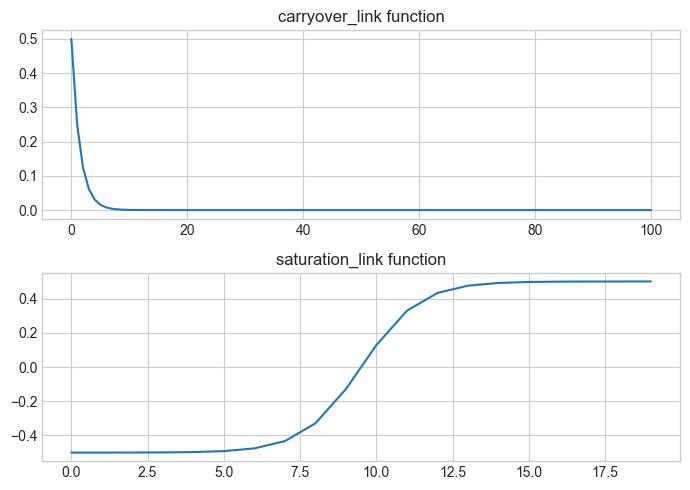

In [9]:
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

def linear_link(x, scale = 1, mean = 0):
    return scale * x + mean

def saturation_link(x, alpha = 1, beta = 1):
    return alpha * (1 / (1 + np.exp(-beta*x)) - 0.5)

def carryover_link(x, k = 0.5, l = 30):
    # we use exponential decay weights w_t ~ exp(k^t)
    # another reasonable alternative is gaussian weights w_t ~ exp(-(t-t_0)^2)
    w = np.array([ np.power(k, i) for i in range(l) ])
    xx = np.vstack([ np.append(np.zeros(i), x[:len(x)-i]) for i in range(l) ])
    y = np.dot(w/np.sum(w), xx)
    return y

def saturation_and_carryover_link(x, alpha, beta, k):
    x_sat = saturation_link(x, alpha, beta)
    return carryover_link(x_sat, k)

def create_mediamix_data(links):    
    # two years of data, daily resolution
    idx = pd.date_range(start='2018-01-01', end='2020-01-01', freq='D') 

    df = pd.DataFrame(index=idx, dtype=float)
    df = df.fillna(0.0)
    
    n = len(df.index)
    
    channel_activity = [step_series(n, 0, 1.0, 80), step_series(n, 0, 1.0, 80)]
    channel_activity_links = [ links[i](channel_activity[i]) for i in range(len(links)) ]
    
    noise = 0.1 * np.random.randn(n)
    
    conversions = np.sum(channel_activity_links, axis=0) + noise
    
    df['conversions'], df['noise'] = conversions, noise
    for i in range(len(links)):
        df[f'channel_activity_0{i+1}'] = channel_activity[i]
        df[f'channel_activity_0{i+1}_link'] = channel_activity_links[i]
    
    return df

#
# preview link functions
#
fig, ax = plt.subplots(2, 1, figsize=(7, 5))
impulse = np.append([1], np.zeros(100))
ax[0].plot(carryover_link(impulse))
ax[0].set_title('carryover_link function')
ax[1].plot(saturation_link(np.linspace(-1, 1, 20), alpha=1, beta=10))
ax[1].set_title('saturation_link function')
plt.tight_layout()

#
# link functions
#
num_channels = 2    # number of media channels (covariates)

# Linear generative model
true_lin_param = {'intercept': [0.0, 3.0], 'alpha': [1.0, 2.0]}
links_linear = [functools.partial(linear_link, 
                                  scale=true_lin_param['alpha'][i], 
                                  mean=true_lin_param['intercept'][i]) for i in range(num_channels)] 

# Saturation and carryover (SC) generative model
true_sc_param = {'alpha': [1.0, 1.0], 'beta': [2.0, 10.0], 'k': [0.2, 0.8]}
links_sc = [functools.partial(saturation_and_carryover_link, 
                              alpha=true_sc_param['alpha'][i], 
                              beta=true_sc_param['beta'][i], 
                              k=true_sc_param['k'][i]) for i in range(num_channels)] 

def plot_media_data(df):
    _, ax = plt.subplots(len(df.columns), 
                           figsize=(15, len(df.columns)*1.0),
                           sharex=True, gridspec_kw={'hspace': 0})
    for i, c in enumerate(df.columns):
        ax[i].plot(df.index, df[c])
        ax[i].set_title(c, y=0.8, va="top")
        ax[i].title.set_size(10)
        ax[i].grid(True)

    plt.tight_layout()
    plt.show()
    
def training_set(df):
    x = np.float64( df[['channel_activity_01', 'channel_activity_02']].values.T )
    y = np.float64( df[['conversions']].values.T )
    return x, y

---
## Scenario 1: Linear Links

In this section, we assume linear links and fit a basic linear model using PyMC.

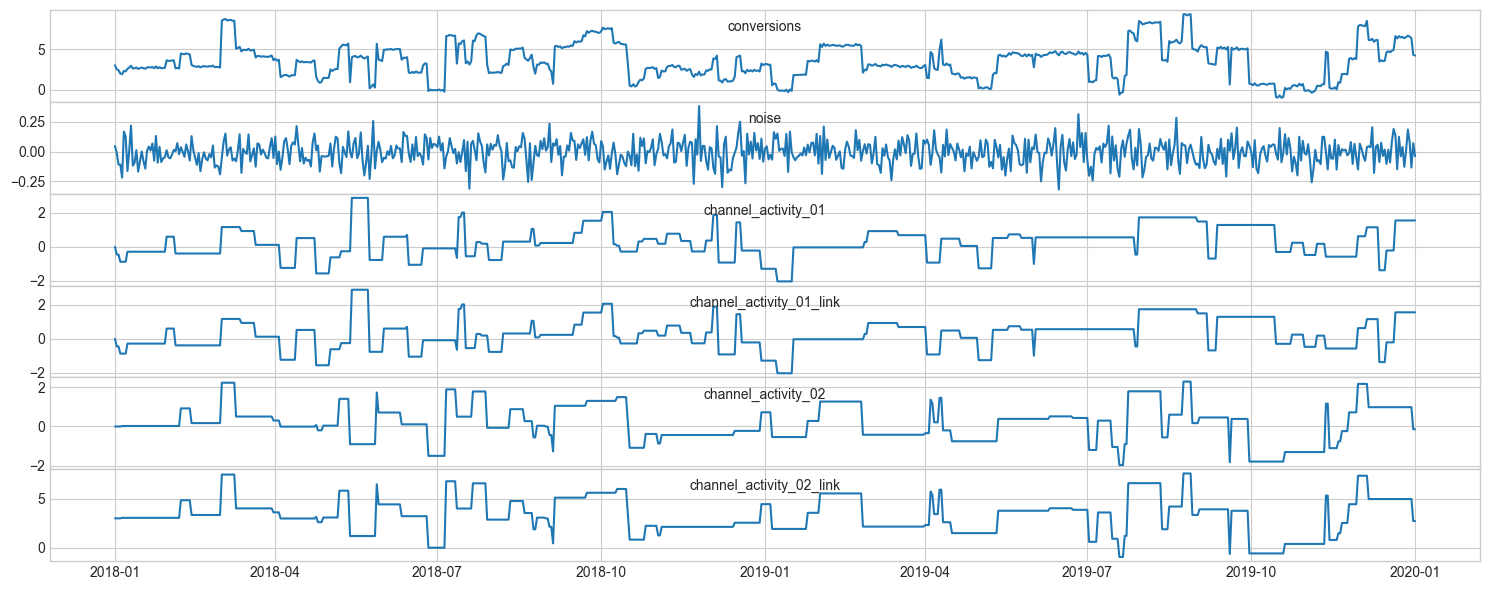

True model parameters [{'intercept': [0.0, 3.0], 'alpha': [1.0, 2.0]}]
x.shape=[(2, 731)], y.shape=[(1, 731)]


Sampling: [alpha, intercept, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, alpha]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


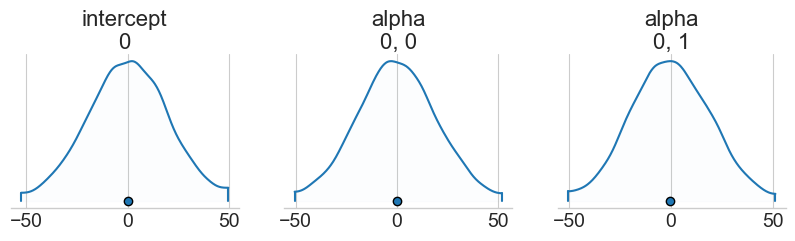

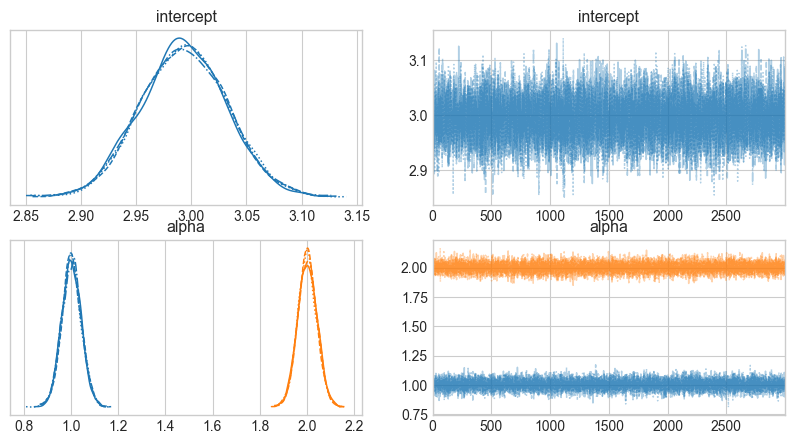

In [4]:
#
# Generate input data with linear links
#
df = create_mediamix_data(links=links_linear)
plot_media_data(df)
print(f'True model parameters [{true_lin_param}]')  
x, y = training_set(df)
print(f'x.shape=[{x.shape}], y.shape=[{y.shape}]')

#
# Model specification
#
with pm.Model() as model: 
    warnings.simplefilter(action='ignore')
    intercept = pm.Normal('intercept', 0, sigma=20, shape=1)
    alpha = pm.Normal('alpha', 0, sigma=20, shape=(1, num_channels))
    likelihood = pm.Normal('y', mu = intercept + pm.math.dot(alpha, x), sigma=1, observed=y) 
 
#
# Visualize priors
#
with model: 
    idata = pm.sample_prior_predictive(samples=5000)
    az.plot_density(idata, group='prior', shade=0.01, hdi_prob=0.99, figsize=(10, 2))
   
#
# Inference using NUTS
#
with model:
    trace = pm.sample(3000, cores=4)
    az.plot_trace(trace, figsize=(10, 5))  

---
## Scenario 2: Saturation and Carryover Links

In this scenario, we simultaneously turn on saturation and carryover effects and fit a model that accounts for both.

True model parameters [{'alpha': [1.0, 1.0], 'beta': [2.0, 10.0], 'k': [0.2, 0.8]}]


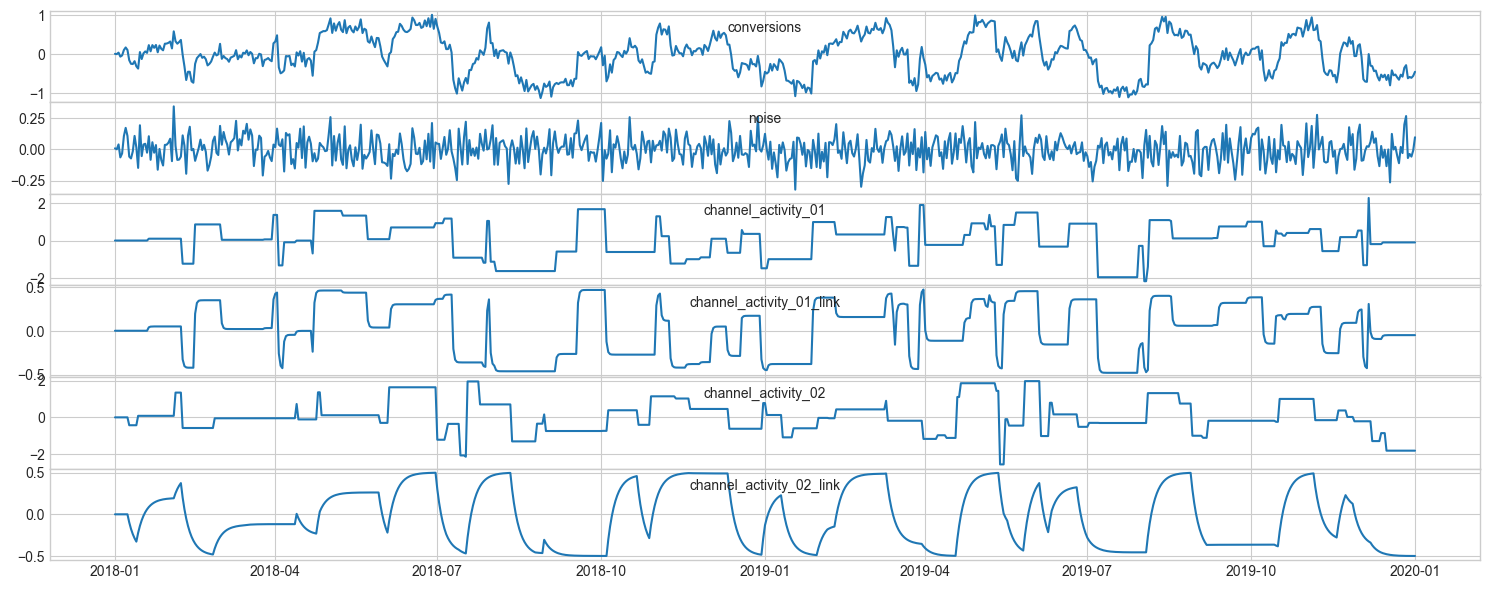

x.shape=[(2, 731)], y.shape=[(1, 731)]


Sampling: [alpha, beta, intercept, k, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, k, intercept, alpha]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 206 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


True model parameters [{'alpha': [1.0, 1.0], 'beta': [2.0, 10.0], 'k': [0.2, 0.8]}]


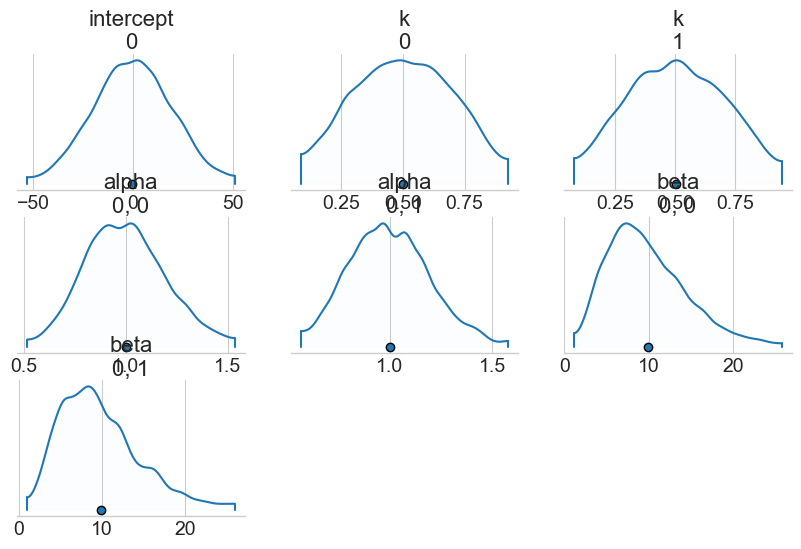

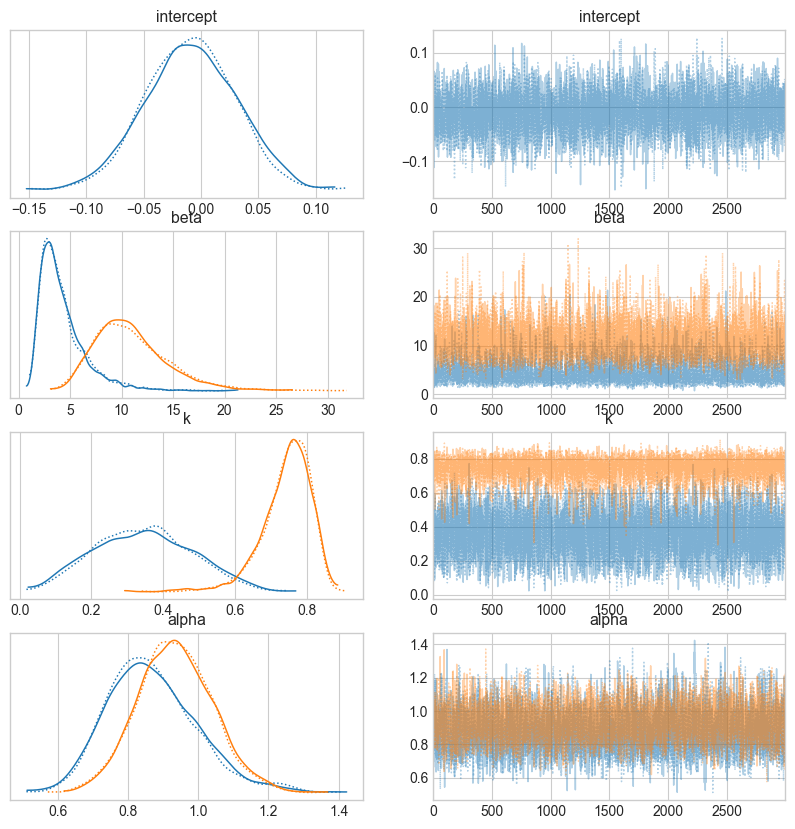

In [12]:
df = create_mediamix_data(links=links_sc)
print(f'True model parameters [{true_sc_param}]')  
x, y = training_set(df)
plot_media_data(df)
print(f'x.shape=[{x.shape}], y.shape=[{y.shape}]')


#
# Model specification:
# The covariates are first transformed using link models
# and then combined into final response
#
def saturation_link_pm(x, beta):
    return pm.math.sigmoid(beta.T * x) - 0.5

def carryover_link_exp_pm(x, k = 0.5, l = 30):
    w = [ k ** i for i in range(l) ]
    xx = pm.math.stack([ pm.math.concatenate([ pm.math.zeros(i), x[:x.shape[0]-i] ]) for i in range(l) ])
    y = pm.math.dot(w/pm.math.sum(w), xx)
    return y
                
with pm.Model() as model: 
    # parameters and priors
    beta = pm.Gamma('beta', mu=10, sigma=5, shape=(1, num_channels))
    k = pm.Beta('k', mu=0.5, sigma=0.2, shape=num_channels)
    intercept = pm.Normal('intercept', 0, sigma=20, shape=1)
    alpha = pm.Gamma('alpha', mu=1, sigma=0.2, shape=(1, num_channels))
    
    # apply link models
    x_saturated = saturation_link_pm(x, beta)
    x_linked = pm.math.stack( [ carryover_link_exp_pm(x_saturated[i,:], k = k[i]) for i in range(num_channels) ] )
     
    # top level regression
    likelihood = pm.Normal('y', mu = intercept + pm.math.dot(alpha, x_linked), sigma=1, observed=y)

#
# Visualize priors
#
with model: 
    idata = pm.sample_prior_predictive(samples=5000)
    az.plot_density(idata, group='prior', shade=0.01, hdi_prob=0.99, figsize=(10, 6)) 
    
#
# Inference using NUTS
#
with model:    
    trace = pm.sample(3000, cores=1)
    az.plot_trace(trace, figsize=(10, 10))

print(f'True model parameters [{true_sc_param}]')